# Network Distances

+ [Distribution Distances](#Distribution-Distances)
    + [Earth Mover's Distance](#Earth-Mover's-Distance)
+ [All Pairs Distances](#All-Pairs-Distances)
    + [Distance-score correlation](#Distance-score-correlation)

---

In [1]:
import importlib

In [2]:
import json

In [3]:
import matplotlib

In [4]:
matplotlib.use('Agg')

In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt

In [7]:
import networkx as nx

In [8]:
import numpy as np

In [9]:
import os

In [10]:
import seaborn as sns

In [11]:
from scipy.stats import spearmanr

---

## Distribution Distances

**2016 March 4-5**

A Google search for "distance between distributions" returned the following potentially useful resources:

+ [What are some measures of the distance between two probability distributions?](https://www.quora.com/What-are-some-measures-of-the-distance-between-two-probability-distributions)
+ [Distance metric between two sample distributions (histograms)](http://mathoverflow.net/questions/103115/distance-metric-between-two-sample-distributions-histograms)
+ [Measuring distance between two empirical distributions](http://stats.stackexchange.com/questions/78405/measuring-distance-between-two-empirical-distributions)

### Earth Mover's Distance

**2016 March 21, 23, 28**

To test out using the earth mover's distance (EMD), a few example probability mass functions (PMFs) will be crafted. These are displayed below:

In [7]:
x = np.arange(1,5)
y1 = np.array([0.4, 0.3, 0.2, 0.1])
y2 = np.array([0.1, 0.2, 0.3, 0.4])
y3 = np.array([0.2, 0.3, 0.3, 0.2])
y4 = np.array([0.0, 1.0, 0.0, 0.0])
y5 = np.array([0.0, 0.0, 0.0, 1.0])

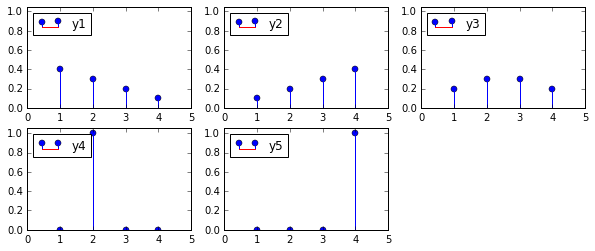

In [12]:
plt.figure(figsize=(10.0,4.0))
for i,y in enumerate([y1, y2, y3, y4, y5]):
    plt.subplot(2,3,i+1)
    plt.stem(x, y, label='y{:d}'.format(i+1))
    plt.xlim(0.0, 5.0)
    plt.ylim(0.0, 1.05)
    plt.legend(loc='upper left')
plt.show()

In the case of 1-D histograms, the EMD between *X* and *Y* is evidently

$$\textrm{EMD}(X,Y) = \sum_{i=1}^n \left|F_X(i) - F_Y(i)\right|$$

where *F*<sub>*X*</sub> and *F*<sub>*Y*</sub> are the cumulative distribution functions (CDFs) of *X* and *Y*, respectively. 

The CDFs for the example PMFs above are:

In [8]:
y1_cdf = np.cumsum(y1)
y2_cdf = np.cumsum(y2)
y3_cdf = np.cumsum(y3)
y4_cdf = np.cumsum(y4)
y5_cdf = np.cumsum(y5)

All of these PMFs are to be compared with a "reference" distribution, defined as $I_{\{1\}}(x) = 1$ if $x=1$ and $0$ otherwise:

In [9]:
yref = np.array([1.0, 0.0, 0.0, 0.0])
yref_cdf = np.cumsum(yref)

In [10]:
for i,cdf in enumerate([y1_cdf, y2_cdf, y3_cdf, y4_cdf, y5_cdf]):
    emd = np.sum(np.fabs(yref_cdf - cdf))
    print('EMD(y_ref, y{:d}) = {:.1f}'.format(i+1, emd))

EMD(y_ref, y1) = 1.0
EMD(y_ref, y2) = 2.0
EMD(y_ref, y3) = 1.5
EMD(y_ref, y4) = 1.0
EMD(y_ref, y5) = 3.0


In the definition of EMD above, it is important to note which values that *i* ranges over. For example, if we are considering an unweighted SGA network (where Dijkstra's algorithm will simply assign 1 to edge weights), then $i\in\mathbb{N}$. 

However, if we are working with the weighted SGA network, then caution should be exercised in choosing values for *i*. For example, suppose sets *X* and *Y* have distances as follows:

$X = \{0.41, 0.60\}$  
$Y = \{0.39, 0.43, 0.56, 0.61\}$

So $P(X=x) = 0.5$ if $x=0.41\textrm{ or }0.60$ and 0 otherwise, and $P(Y=y) = 0.25$ if $y\in\{0.39, 0.43, 0.56, 0.61\}$ and 0 otherwise. It follows that 

In [3]:
%%latex
\[ F_X(x) = \left\{ \begin{array}{ll}
                   0.5, & x\leq 0.41\\
                   1.0, & x\leq 0.60\\
                   1.0, & x > 0.60 \end{array} \right. \]

<IPython.core.display.Latex object>

Now *X* and *Y* should be quite similar in comparison to some reference distribution. But if *i* were to range over the distance values (0.41 and 0.60 for *X*; similarly for *Y*), then this would not be the case under the definition of EMD above. 

Thus, for the weighted SGA network, we shall use a slightly different version of computing the distance between 2 distributions:

$\int_0^{+\infty} \left|F_\textrm{ref}(t) - F_X(t)\right|dt = \sum_i (x_i - x_{i-1})(F_{\textrm{ref}}(x_{i-1}) - F_X(x_{i-1}))$

where the *x*<sub>*i*</sub>'s are the values taken on by the probability mass function (pmf). 

## All Pairs Distances

**2016 March 23-24, 28**

Run Dijkstra's algorithm to calculate the distance between all pairs of nodes in both the SGA negative and positive <u>weighted</u> network. Recall that the edge lists were constructed in *DataProcessing.ipynb*. Note: this is re-running code completed on March 4; the outputs were pickled to *negdist.pkl* and *posdist.pkl*. Here the code is documented and the output saved to JSON instead. 

It is worth noting again that the edge weights in the negative and positive SGA network as used here are the reversed genetic interaction scores &epsilon; (see *DataProcessing.ipynb*) - meaning that the largest &epsilon; is now the smallest, the 2<sup>nd</sup> largest is now the 2<sup>nd</sup> smallest, etc. This is so that stronger interactions are closer in the network as would be measured by something like Dijkstra's algorithm. 

In [4]:
negEdgeFile = os.path.join('..', 'data', 'neg_sga_edgelist.txt')
G_neg = nx.read_weighted_edgelist(negEdgeFile, delimiter='\t')

In [5]:
%time negdist = nx.all_pairs_dijkstra_path_length(G_neg)

CPU times: user 15min 47s, sys: 624 ms, total: 15min 47s
Wall time: 15min 47s


In [6]:
negsavepath = os.path.join('..', 'data', 'negdist.json')
json.dump(negdist, open(negsavepath, 'w'))

In [4]:
posEdgeFile = os.path.join('..', 'data', 'pos_sga_edgelist.txt')
G_pos = nx.read_weighted_edgelist(posEdgeFile, delimiter='\t')

In [5]:
%time posdist = nx.all_pairs_dijkstra_path_length(G_pos)

CPU times: user 8min 47s, sys: 510 ms, total: 8min 47s
Wall time: 8min 47s


In [6]:
possavepath = os.path.join('..', 'data', 'posdist.json')
json.dump(posdist, open(possavepath, 'w'))

Next, calculate distances between all pairs of nodes in the SGA negative and positive <u>unweighted</u> network (recall that intermediate cutoff is used). Effectively, the genetic interactions are binarized - either gene pairs interact, or not at all. This will be used first in computing the distance between drug pair targets. Prepare the edgelists:

    cut -f1-2 neg_sga_edgelist.txt > neg_sga_unweight.txt
    cut -f1-2 pos_sga_edgelist.txt > pos_sga_unweight.txt

In [5]:
uwG_neg = nx.read_edgelist(os.path.join('..', 'data', 'neg_sga_unweight.txt'))

In [6]:
%time negdistuw = nx.all_pairs_shortest_path_length(uwG_neg)

CPU times: user 2min 8s, sys: 176 ms, total: 2min 9s
Wall time: 2min 9s


In [7]:
json.dump(negdistuw, open(os.path.join('..', 'data', 'negdistuw.json'), 'w'))

In [5]:
uwG_pos = nx.read_edgelist(os.path.join('..', 'data', 'pos_sga_unweight.txt'))

In [6]:
%time posdistuw = nx.all_pairs_shortest_path_length(uwG_pos)

CPU times: user 1min 13s, sys: 216 ms, total: 1min 14s
Wall time: 1min 14s


In [7]:
json.dump(posdistuw, open(os.path.join('..', 'data', 'posdistuw.json'), 'w'))

### Distance-score correlation

**2016 March 28-29**

<u>Question:</u> Over all gene pairs, is there any correlation between their genetic interaction scores &epsilon; and their distance in the genetic interaction network? (Again, the network has edge weights as all the &epsilon; reversed.) The approach is to iterate through the raw SGA screening data *sgadata_costanzo2009_rawdata_101120.txt* and consider each gene pair having &epsilon; &ne; NaN and p-value &lt; 0.05. This only works if both genes appear somewhere in the interaction network. Negative and positive genetic will be considered separately. Created *intactDistCorr.py* which contains a function *get_plot_data()* to return network distances and &epsilon;'s for either negative or positive genetic. 

In [12]:
os.chdir(os.path.join('..', 'src'))

In [13]:
import intactDistCorr

In [14]:
negScores, negDists = intactDistCorr.get_plot_data('negative')

Using negative genetic...


In [24]:
sns.set_style("whitegrid")
sns.set_context(context="notebook", font_scale=1.5)

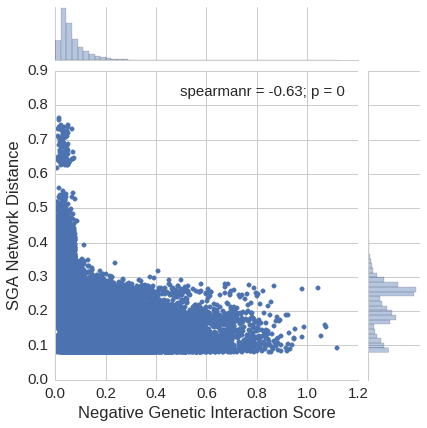

In [25]:
g = sns.jointplot(negScores, negDists, stat_func=spearmanr, xlim=(0.0,1.2), ylim=(0.0,0.9))
g.set_axis_labels('Negative Genetic Interaction Score', 'SGA Network Distance')

In [26]:
posScores, posDists = intactDistCorr.get_plot_data('positive')

Using positive genetic...


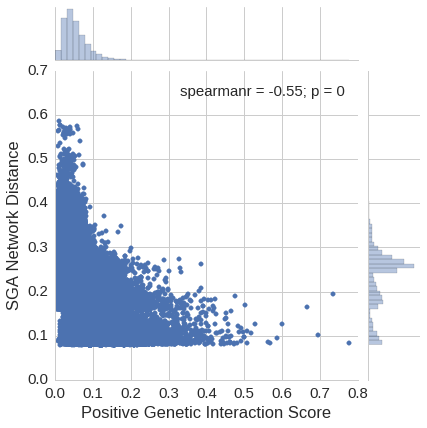

In [28]:
g_pos = sns.jointplot(posScores, posDists, stat_func=spearmanr, xlim=(0.0,0.8), ylim=(0.0,0.7))
g_pos.set_axis_labels('Positive Genetic Interaction Score', 'SGA Network Distance')